# Lab Instructions

You have been hired by James Cameron to create profiles of two characters for a reboot of the Titanic Movie: one that is most likely to survive the sinking and one that is least likely to survive.  Mr. Cameron wants this reboot to be as historically accurate as possible, so your profile of each character should be backed up with data and visualizations.

Each character profile should include information on their:
* Age, fare
* Sex
* Passenger class
* Travel companions (including both parents/children and siblings/spouse)
* Port of departure

For quantitative features like `Age` and `Fare`, you will need to use the `.loc` method we learned in class (or something similar) to place individuals in categories.  How you choose to do this is up to you, but make sure you explain your reasoning.

You should include at least one visualization for each element of the character profile (age, sex, passenger class, etc.) as evidence.

After you have developed your two character profiles, use your Pandas data wrangling skills to identify at least one real passenger in the dataset that fits each profile.  Print out the names of these individuals.  Look them up in [Encyclopeida Titanica](https://www.encyclopedia-titanica.org/) (or a similar resource).  

Tell Mr. Cameron at least one thing about the real passengers who fit your two character profiles that you learned from an external resource.  You need one interesting fact about a person who fits the profile of "most likely to survive" and one interesting fact about a person who fits the profile of "least likely to surivive".  



In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
df = pd.read_csv('titanic_passengers.csv');


## Concerned categories:
* Age -> make into child (0-9), adolescent (10-19), adult(> 19) as defined by WHO
* Fare -> make into 4 categories, just use the percentiles...
* PClass -> 1 is upper, 2 is middle, 3 is lower
* Companions -> Parch + SibSp
* Embarked -> C is Cherbourg, Q is Queenstown, S is Southampton

We will convert the Parent/Child category to Single, Pair, and Group, because there are undeniable social consequences to these groupings. A person on their own has nobody to depend on. A pair likely has a very strong bond to be there together, and so will probably act to help each other. A group is more complex because there are many group dynamics to be considered; there is strength in numbers yes, but also hesitation and uncertain, such as diffusion of responsibility, to name one.

In [32]:
df.loc[df['Parch'] + df['SibSp'] == 0, 'Companions'] = '0Single'
df.loc[df['Parch'] + df['SibSp'] == 1, 'Companions'] = '1Pair'
df.loc[df['Parch'] + df['SibSp'] >  1, 'Companions'] = '2Group'

We will split the age groups into minor, adult, and senior. This is because minors will be dependent, adults should be primarily independent, and seniors are also dependents. We will assume all unlisted ages are adults, because it seems the most accepted practice is to take the median age of the group and apply that. However, I do not wish to alter the data outside of the rows that I create, so I will let the ages be NaN to indicate that the data does not actually exist, but make those records in my own group be the same group as the median age. Since the median age is 28, we will make the default AgeGroup 'Adult'

In [33]:
df.loc[df['Age'] >= 65, 'AgeGroup'] =   '2Senior'  # Senior
df.loc[df['Age'] < 65, 'AgeGroup'] =    '1Adult'   # Adult
df.loc[df['Age'] <=  18, 'AgeGroup'] =  '0Child'   # Minor
df['AgeGroup'] = df['AgeGroup'].fillna('1Adult')   # Default (adult)

I don't see much value in categorizing the fare when the passenger class data is available, so I am categorizing the fare in the most 'fair' way, such that each group has the same number of people.

In [34]:
df.loc[df['Fare'] <= df['Fare'].quantile(3 / 3), 'FareGroup'] = 'Q3'
df.loc[df['Fare'] <= df['Fare'].quantile(2 / 3), 'FareGroup'] = 'Q2'
df.loc[df['Fare'] <= df['Fare'].quantile(1 / 3), 'FareGroup'] = 'Q1'

Lastly, we will populate the missing data for 'Embarked' with whichever port was most popular because it seems like most people will fill blank data with data that best represents the whole.

In [35]:
most_common_port = df['Embarked'].mode()
df['Embarked'] = df['Embarked'].fillna(most_common_port[0])

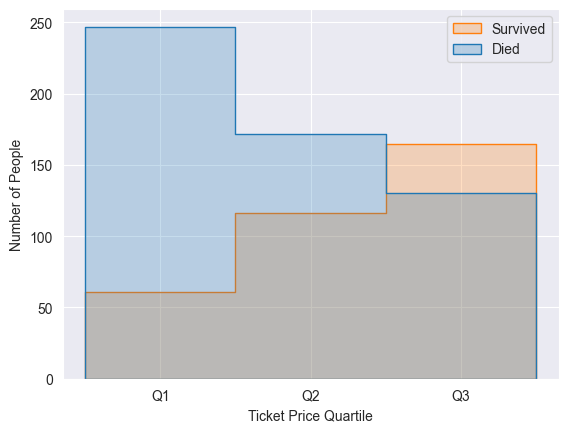

In [36]:
sns.histplot(data=df.sort_values('FareGroup'), x='FareGroup', hue='Survived', element='step')
plt.legend(['Survived', 'Died'])
plt.title = "Survivorship on the Titanic Based on Fare"
plt.ylabel('Number of People')
plt.xlabel('Ticket Price Quantile')
plt.show() # I have no clue why it's not showing the title...

Looking for the points where the 'Survived' is higher than the died, we see this is only true for the third quantile of fare price. We can see that there is a sharp and consistent rise in survivorship as the fare price rises. This suggests a strong relationship between the fare price and survivorship.

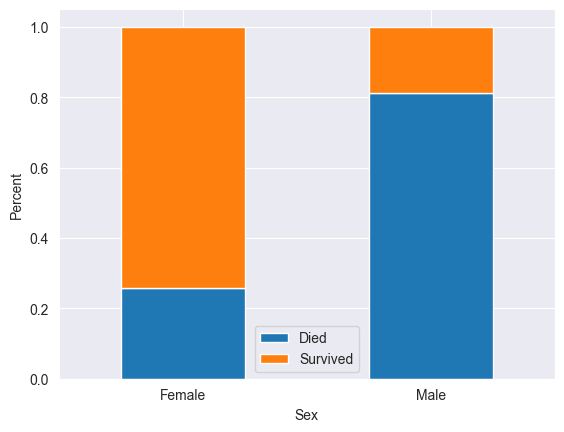

In [37]:
sex_survived_ct = pd.crosstab(df['Sex'], df['Survived'], normalize='index')
sex_survived_ct.plot(kind='bar', stacked=True)
plt.ylabel('Percent')
plt.xticks([0, 1], ['Female', 'Male'], rotation=0)
plt.legend(['Died', 'Survived']) # I have no clue what's going on here... I directly copied and pasted from my cell above and that didn't fix it...
plt.title='Survivorship on the Titanic Based on Sex'

plt.show();

We can see that the male bar looks like the female bar flipped. Females had a far greater chance of survival than males did, suggesting a very strong relation between survivorship and passenger sex.

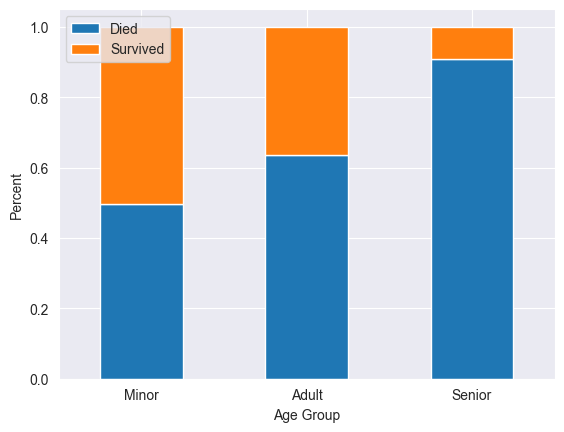

In [38]:
agegroup_survived_ct = pd.crosstab(df['AgeGroup'], df['Survived'], normalize='index')
agegroup_survived_ct.plot(kind='bar', stacked=True)
plt.xticks([0, 1, 2], ['Minor', 'Adult', 'Senior'], rotation=0)
plt.ylabel('Percent')
plt.xlabel('Age Group')
plt.legend(['Died', 'Survived']) # I have no clue what's going on here... I directly copied and pasted from my cell above and that didn't fix it...
plt.title='Survivorship on the Titanic Based on Sex'

plt.show();

We can see that as age increases, survivorship decreases. This implies a strong relationship between age and survivorship.

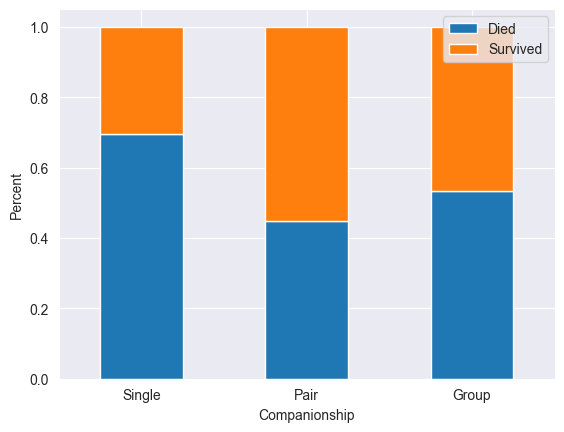

In [39]:
companions_survived_ct = pd.crosstab(df['Companions'], df['Survived'], normalize='index')
companions_survived_ct.plot(kind='bar', stacked=True)
plt.xticks([0, 1, 2], ['Single', 'Pair', 'Group'], rotation=0)
plt.ylabel('Percent')
plt.xlabel('Companionship')
plt.legend(['Died', 'Survived']) # I have no clue what's going on here... I directly copied and pasted from my cell above and that didn't fix it...
plt.title='Survivorship on the Titanic Based on Number of Travel Companions'

plt.show()

We see the greatest chance of survival from pairs of people, followed by groups, then by single passengers, suggesting that there is a relationship between the number of travel companions and survival, but that there is a limit before travel companions start lowering the chance of survival.

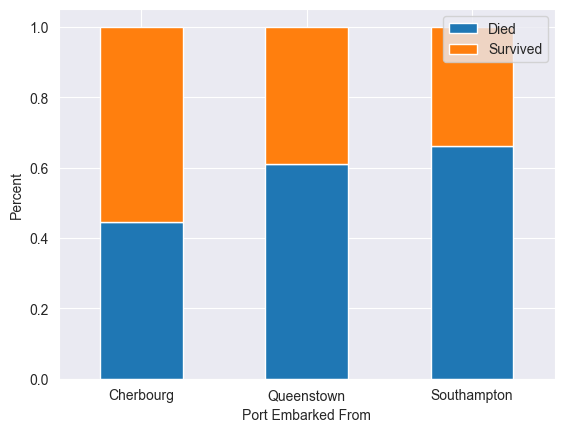

In [40]:
# C is Cherbourg, Q is Queenstown, S is Southampton
embarked_survived_ct = pd.crosstab(df['Embarked'], df['Survived'], normalize='index')
embarked_survived_ct.plot(kind='bar', stacked=True)
plt.xticks([0, 1, 2], ['Cherbourg', "Queenstown", "Southampton"], rotation=0)
plt.ylabel('Percent')
plt.xlabel('Port Embarked From')
plt.legend(['Died', 'Survived']) # I have no clue what's going on here... I directly copied and pasted from my cell above and that didn't fix it...
plt.title='Survivorship on the Titanic Based on Embarked Port'

plt.show()

We can see the greatest chance at survival from people who departed from Cherbourg, the second greatest Queenstown, and the least chance of survival from people who departed from Southampton.

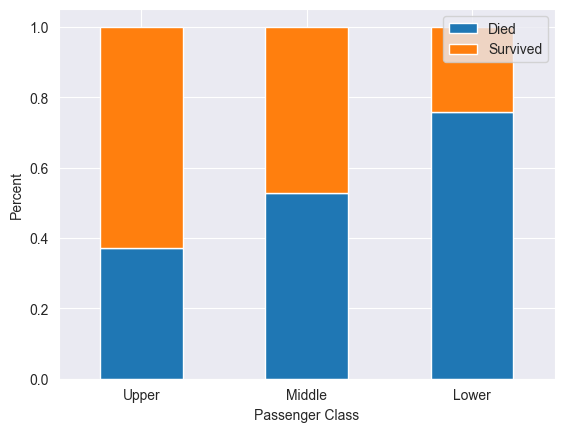

In [41]:
#1 is upper, 2 is middle, 3 is lower

class_survived_ct = pd.crosstab(df['Pclass'], df['Survived'], normalize='index')
class_survived_ct.plot(kind='bar', stacked=True)
plt.xticks([0, 1, 2], ['Upper', 'Middle', 'Lower'], rotation=0)
plt.ylabel('Percent')
plt.xlabel('Passenger Class')
plt.legend(['Died', 'Survived']) # I have no clue what's going on here... I directly copied and pasted from my cell above and that didn't fix it...
plt.title='Survivorship on the Titanic Based on Passenger Class'

plt.show()

In [42]:
# I was trying out alternative methods of representing data. But I don't think we want the majority of who survived, but the group who, if someone was part of, they would be most likely to survive.
# Just making some slightly prettier categories
'''df.loc[df['Pclass'] == 1, 'Pclass_pretty'] = 'Upper'
df.loc[df['Pclass'] == 2, 'Pclass_pretty'] = 'Middle'
df.loc[df['Pclass'] == 3, 'Pclass_pretty'] = 'Lower'

df.loc[df['Survived'] == 0, 'Survived_pretty'] = 'Died'
df.loc[df['Survived'] == 1, 'Survived_pretty'] = 'Survived'
px.sunburst(data_frame=df, path=['Survived_pretty', 'Sex', 'Embarked', 'AgeGroup', 'Pclass_pretty', 'Companions', 'FareGroup'], width=960, height=900, labels=['Survival', 'Sex', 'Departure', 'Age', 'Ticket Class', 'Companions', 'Fare value quartile'])
''';

#I determined the majority of survivors by finding the largest group at the edge of the red in the graphic above. The majority of survivors were single, adult women departing from Southampton, who bought a middle class fare in the second quartile of values (somewhere between 7.91 and 14.45 pounds or dollars)

#The majority of the dead, I got with the same process, except searching the blue. With little competition, the majority of the dead were single adult men departing from Southampton, who bought a lower class fare in the cheapest quartile of values (somewhere between 0 and 7.91)

In the above cell, which is commented out, we establish the majority of survivors by finding the largest group at the edge of the red in the graphic above. The majority of survivors were single, adult women departing from Southampton, who bought a middle class fare in the second quartile of values (somewhere between 7.91 and 14.45 pounds or dollars)

The majority of the dead, I got with the same process, except searching the blue. With little competition, the majority of the dead were single adult men departing from Southampton, who bought a lower class fare in the cheapest quartile of values (somewhere between 0 and 7.91).

If they wanted to make a film to represent someone in the majority of the living or the majority of the dead, these would be the character profiles they should choose.

However, I believe the producers want to make a film about the most likely to survive were they in that group. In which case, if we look at all the graphs we have made, it seems that the traits for the most likely to survive protagonist would be an upper class female child who came with one other person (hopefully a guardian), departing from Cherbourg, who bought their ticket in the fourth quartile of ticket prices.

The traits our unfortunate protagonist would have in if we wanted to group them in with the least likely to survive would be a lower-class adult male, embarking alone from Southampton, who bought their ticket in the first quartile of ticket prices.

Since there was no real passenger which meets our criteria, below is a list of female children who came with a guardian:


In [48]:
df.query('Pclass == 1 and Sex == "female" and AgeGroup == "0Child" and Companions == "1Pair" and Embarked == "C" and FareGroup == "Q3"')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Companions,AgeGroup,FareGroup
307,308,1,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,1,0,PC 17758,108.9000,C65,C,1Pair,0Child,Q3
329,330,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C,1Pair,0Child,Q3
700,701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,PC 17757,227.5250,C62 C64,C,1Pair,0Child,Q3


From this dataset we see that all of the passengers which fit this narrow criteria survived! Good for them!

Below will be a list of the least likely passengers to survive

In [49]:
df.query('Pclass == 3 and Sex == "male" and AgeGroup == "2Senior" and Companions == "0Single" and Embarked == "S" and FareGroup == "Q1"')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Companions,AgeGroup,FareGroup
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.775,NaN,S,0Single,2Senior,Q1


From this dataset we see that the only man who met all these criteria died.

An interesting fact about Mr. Johan Svensson is that he was the oldest person aboard the ship. Sensing he was going to die soon, he wanted to spend what little time he had left with his family in America, but that didn't pan out. :( https://www.encyclopedia-titanica.org/titanic-victim/johan-svensson.html I could not find another free resource that mentioned Johan Svensson Sr. most sources were about the 19 year-old sailor also aboard the Titanic.

An interesting fact about Mrs. John Jacob Astor is that she married a number of times, and had trouble doing since after her first marriage, due to the social stigmas of the time. Priests refused to marry her to another man. https://www.newyorksocialdiary.com/the-life-in-the-house-and-the-house-in-the-life-of-mrs-astor/